<center>
    <h1> ILI286 - Computación Científica II  </h1>
    <h2> Ecuaciones Diferenciales Parciales: Elípticas </h2>
    <h2> [S]cientific [C]omputing [T]eam</h2>
    <h2> Version: 1.13</h2>
</center>

# Tabla de Contenidos
* [Introducción](#intro)
* [Marco Teórico](#teo)
* [Ecuación de Poisson](#poisson)
* [Ecuación de Helmotz](#helmotz)
* [Acknowledgements](#acknowledgements)

In [2]:
import numpy as np
from numpy.linalg import solve
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
from matplotlib import pyplot as plt

def plot(x,y,w):
    # Plot the solution
    X,Y = np.meshgrid(y,x)
    W = w.reshape(X.shape)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_wireframe(X, Y, W)
    #ax.plot_surface(X, Y, W, alpha=0.25)
    plt.xlabel("y")
    plt.ylabel("x")
    #ax.set_zlim(0.,1.)
    #plt.savefig("sol%dx%d.png"%(Nx+1,Ny+1))
    plt.show()

<div id='intro' />

# Introducción

En el siguiente notebook se estudia la resolución numérica de **ecuaciones diferenciales parciales elípticas**. La resolución de estas tiene gran importancia, ya que aparecen repetidas veces en diferentes modelos físicos relacionados con los potenciales de energía. Por ejemplo, el potencial de carga eléctrica de acuerdo a las ecuaciones de _Maxwell_ puede ser escrito como:
$$
\Delta u = -\frac{\rho}{\epsilon},
$$
con $u$ el potencial eléctrico, $\rho$ la densidad de carga, y $\epsilon$ el la permitividad eléctrica.

El método numérico que estudiaremos se basa en **diferencias finitas**, del mismo modo en que se hizo para resolver EDOs anteriormente, esto es, las derivadas son aproximadas por gradientes calculados numéricamente en base a los valores vecinos de cada punto. Sin embargo ahora *las derivadas son parciales!*, pero como veremos esto no es gran problema.

<div id='teo' />

# Marco Teórico


Si consideramos una función $u(x,y)$ dos veces diferenciable, entonces se define el operador *Laplaciano* como:

$$
\Delta u(x,y) = u_{xx}(x,y) + u_{yy}(x,y),
$$

si se considera además una función $f(x,y)$, entonces es posible definir:

$$
\Delta u(x,y) = u_{xx}(x,y) + u_{yy}(x,y) = f(x,y), \ \ \  \text{con } \ x,y \in \Omega \ \text{ y condiciones de borde en } \ \partial \Omega
$$

como la **ecuación de Poisson**, la cual es una de las más conocidas dentro de la clase _ Elípticas _. El caso particular donde $f(x,y) = 0$ se conoce como **ecuación de Laplace**.


### Formulación numérica

Sea la ecuación de Laplace $\Delta u(x,y) = 0$ sobre un dominio rectangular $[x_a, x_b] \times [y_a, y_b]$, con condiciones de borde de Dirichlet:

\begin{align}
    u(x,y_a) &= g_1(x) \\
    u(x,y_b) &= g_2(x) \\
    u(x_a,y) &= g_3(y) \\
    u(x_b,y) &= g_4(y) .
\end{align}

Para resolver este problema por diferencias finitas, es necesario discretizar el dominio $\Omega$ sobre el que se define la función. Tal discretización se puede ver gráficamente como se muestra a continuación:

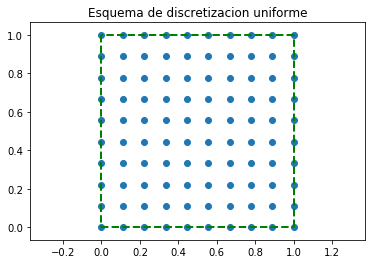

In [3]:
x = np.linspace(0., 1., 10)
y = np.linspace(0., 1., 10)
xgrid, ygrid = np.meshgrid(x, y, sparse=False)
plt.scatter(xgrid.ravel(), ygrid.ravel())
plt.plot((0,1),(0,0), 'g--' ,lw=2)
plt.plot((1,1),(0,1), 'g--' ,lw=2)
plt.plot((1,0),(1,1), 'g--' ,lw=2)
plt.plot((0,0),(1,0), 'g--' ,lw=2)
plt.title('Esquema de discretizacion uniforme')
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.axis('equal')
plt.show()

en donde cada punto interior (*azul*), representa un punto donde queremos conocer el valor de la función $u(x,y)$. Consideraremos además que  $h_x$ y $h_y$ el *space step* de la malla.  

Dado que las derivadas del Laplaciano son *parciales*, se puede utilizar diferencias finitas sin ninguna modificación. Para aproximar cada segunda derivada se utiliza *diferencias centradas* (**centered difference formula**), que posee un error de orden cuadrático en $h$.

$$
\underbrace{ \frac{u(x-h_x,y) - 2 u(x,y) + u(x+h_x, y)}{h_x^2} + O(h_x^2) }_{= u_{xx}(x,y)} + \underbrace{ \frac{u(x,y-h_y) - 2 u(x,y) + u(x, y+h_y)}{h_y^2} + O(h_y^2) }_{= u_{yy}(x,y)} = f(x,y)
$$

Ocupando la notación $u(x_i,y_j) = w_{ij}$ para el punto $(x_i, y_j)$ de la malla, la ecuación de discretización es finalmente:

$$
\frac{w_{i-1,j} - 2 w_{i,j} + w_{i+1,j}}{h_x^2} + \frac{w_{i,j-1} - 2 w_{i,j} + w_{i,j+1}}{h_y^2} \approx f(x_i, y_j),
$$

válida para todos los puntos $(x_i, y_j) \in \Omega - \partial \Omega$ (puntos interiores). Hay una aspecto muy importante a notar: **Esta ecuación es lineal en los $\mathbf{w_{i,j}}$!**. El procedimiento es entonces como sigue:

* Evaluar la ecuación discretizada para cada punto interior $(x_i, y_j)$, utilizando la información de los valores en la frontera.
* Construir un sistema lineal $A \mathbf{w} = b$, en donde $\mathbf{w}$ es el vector con todos los $w_{i,j}$. (Para su construcción revisar el libro guía: *Numerical Analysis, Timothy Sauer*).
* Resolver el sistema anterior para $\mathbf{w}$, utilizando cualquier `solver` de sistemas lineales (LU, PALU, Jacobi, Gauss-Seidel, etc).

# Ecuación de Poisson

Buscaremos resolver la ecuación de Poisson con condición de frontera de Dirichlet:

\begin{align*}
u_{xx}(x,y) + u_{yy}(x,y) = f(x,y) \ , \ x, y \in [0,1]\times[0,1] \\
\end{align*}

\begin{align*}
u(x,0) = b(x)
\end{align*}

\begin{align*}
u(x,1) = t(x)
\end{align*}

\begin{align*}
u(0, y) = l(y)
\end{align*}

\begin{align*}
u(1,y) = r(y)
\end{align*}

A continuación se definen tres problemas de Poisson a resolver.

In [4]:
# Problema 1
xmin, xmax = -1, 1.
ymin, ymax = -1, 1.
f  = lambda x,y : x*y
bottom = lambda x : 0# np.sin(np.pi*x)
top = lambda x : 0 #np.sin(np.pi*x)
left = lambda y : 0
right = lambda y: 0
P1 = {"f":f, "b":bottom, "t":top, "l":left, "r":right, 
      "xmin":xmin, "xmax":xmax, "ymin":ymin, "ymax":ymax}

# Problema 2
xmin, xmax = 0., 1.
ymin, ymax = 0., 1.
f  = lambda x,y : x
bottom = lambda x : np.sin(np.pi*x)
top = lambda x : np.sin(np.pi*x)
left = lambda y : 0
right = lambda y: 0
P2 = {"f":f, "b":bottom, "t":top, "l":left, "r":right, 
      "xmin":xmin, "xmax":xmax, "ymin":ymin, "ymax":ymax}

# Problema 3
xmin, xmax = -1, 1.
ymin, ymax = -1, 1.
f  = lambda x,y : 0
bottom = lambda x : 0
top = lambda x : 0
left = lambda y : np.sin(np.pi*y)
right = lambda y: -np.sin(np.pi*y)
P3 = {"f":f, "b":bottom, "t":top, "l":left, "r":right, 
      "xmin":xmin, "xmax":xmax, "ymin":ymin, "ymax":ymax}

# Problema 4
xmin, xmax = 0, 1.
ymin, ymax = 0, 1.
f  = lambda x,y : x*np.exp(y)
bottom = lambda x : x
top = lambda x : x*np.exp(1)
left = lambda y : 0*y
right = lambda y: np.exp(y)
P4 = {"f":f, "b":bottom, "t":top, "l":left, "r":right, 
      "xmin":xmin, "xmax":xmax, "ymin":ymin, "ymax":ymax}

La función `solve_laplace()` es la encargada de construir el sistema lineal correspondiente para al problema `P` a resolver.

**Q:** _¿Podría usted explicar esta construcción en base a lo visto en la formulación teórica?_.

In [5]:
def solve_laplace(P, Nx, Ny):
    # Discretize x and y
    x = np.linspace(P["xmin"], P["xmax"], Nx+1)
    y = np.linspace(P["ymin"], P["ymax"], Ny+1)

    # Define the discretization parameters
    dx = x[1]-x[0]
    dy = y[1]-y[0]
    
    # Create the matrix and the right hand size vector
    A = np.zeros([(Nx+1)*(Ny+1), (Nx+1)*(Ny+1)])
    b = np.zeros([(Nx+1)*(Ny+1), 1])
        
    # Define global indexing
    def index(i, j, nCols=(Ny+1)):
        return j + i*nCols
    
    # Fill up the matrix and right hand side vector
    for i in range(Nx+1):
        for j in range(Ny+1):
            k = index(i,j)
            if j==0: # y=ymin, bottom
                A[k,k] =  1.
                b[k] = P["b"](x[i])
            elif i==Nx: # x=xmax, right
                A[k,k] =  1.
                b[k] = P["r"](y[j])
            elif j==Ny: # y=ymax, top
                A[k,k] =  1.
                b[k] = P["t"](x[i])
            elif i==0:  # x=xmin, left
                A[k,k] =  1.
                b[k] = P["l"](y[j])
            else:
                A[k, k] = -2./dx**2 - 2./dy**2
                A[k,index(i+1,j)] =  1./dx**2
                A[k,index(i-1,j)] =  1./dx**2
                A[k,index(i,j-1)] =  1./dy**2
                A[k,index(i,j+1)] =  1./dy**2
                b[k] = P["f"](x[i], y[j])

    # Solve the linear system
    w = solve(A, b)
    return x, y, w

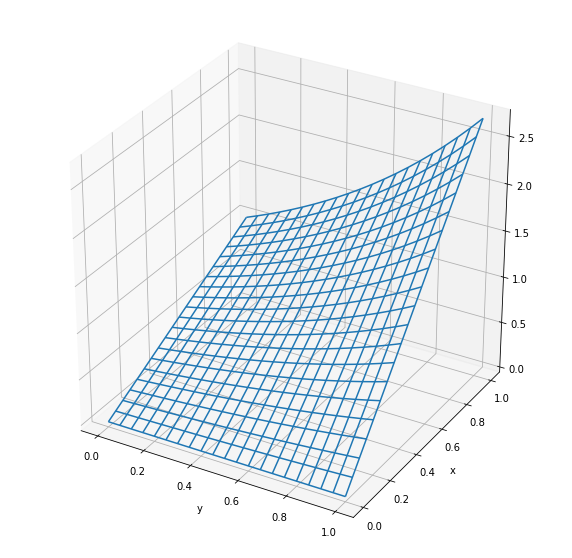

In [6]:
P = P4
x, y, u = solve_laplace(P, Nx=20, Ny=20)
plot(x,y,u)

# Ecuación de Helmoltz

In [7]:
# Problem 1
Lambda = 0.0
xmin, xmax = 0., 1.
ymin, ymax = 0., 1.
f  = lambda x,y : 0
bottom = lambda x : 0
top = lambda x : 0
left = lambda y : 1
right = lambda y: 1
P1 = {"Lambda":Lambda, "f":f, "b":bottom, "t":top, "l":left, "r":right, 
      "xmin":xmin, "xmax":xmax, "ymin":ymin, "ymax":ymax}

# Problem 2
Lambda = 2.0
xmin, xmax = 0., 1.
ymin, ymax = 0., 1.
f  = lambda x,y : 0
bottom = lambda x : 0
top = lambda x : 0
left = lambda y : 1
right = lambda y: 1
P2 = {"Lambda":Lambda, "f":f, "b":bottom, "t":top, "l":left, "r":right, 
      "xmin":xmin, "xmax":xmax, "ymin":ymin, "ymax":ymax}

# Problem 3
Lambda = 0.0
xmin, xmax = -1, 1.
ymin, ymax = -1, 1.
f  = lambda x,y : 0
bottom = lambda x : 0
top = lambda x : 0
left = lambda y : np.sin(np.pi*y)
right = lambda y: -np.sin(np.pi*y)
P3 = {"Lambda":Lambda, "f":f, "b":bottom, "t":top, "l":left, "r":right, 
      "xmin":xmin, "xmax":xmax, "ymin":ymin, "ymax":ymax}

La función `solve_herlmotz()` es la encargada de construir el sistema lineal correspondiente para al problema `P` a resolver.

**Q:** _¿Podría usted explicar esta construcción en base a lo visto en la formulación teórica?_.

In [8]:
def solve_helmholtz(P, Nx, Ny):
    # Discretize x and y
    x = np.linspace(P["xmin"], P["xmax"], Nx+1)
    y = np.linspace(P["ymin"], P["ymax"], Ny+1)
    L = P["Lambda"]

    # Define the discretization parameters
    dx = x[1]-x[0]
    dy = y[1]-y[0]
    
    # Create the matrix and the right hand size vector
    A = np.zeros([(Nx+1)*(Ny+1), (Nx+1)*(Ny+1)])
    b = np.zeros([(Nx+1)*(Ny+1), 1])
        
    # Define global indexing
    def index(i, j, nCols=(Ny+1)):
        return j + i*nCols
    
    # Fill up the matrix and right hand side vector
    for i in range(Nx+1):
        for j in range(Ny+1):
            k = index(i,j)
            if j==0: # y=ymin, bottom
                A[k,k] =  -1.5/dy
                A[k,index(i,j+1)] = 2.0/dy
                A[k,index(i,j+2)] =-0.5/dy
                b[k] = P["b"](x[i])
            elif i==Nx: # x=xmax, right
                A[k,k] =  1.
                b[k] = P["r"](y[j])
            elif j==Ny: # y=ymax, top
                A[k,k] =  1.5/dy 
                A[k,index(i,j-1)] =  -2.0/dy
                A[k,index(i,j-2)] =  +0.5/dy
                b[k] = P["t"](x[i])
            elif i==0:  # x=xmin, left
                A[k,k] =  1.
                b[k] = P["l"](y[j])
            else:
                A[k, k] = -2./dx**2 - 2./dy**2 - L
                A[k,index(i+1,j)] =  1./dx**2
                A[k,index(i-1,j)] =  1./dx**2
                A[k,index(i,j-1)] =  1./dy**2
                A[k,index(i,j+1)] =  1./dy**2
                b[k] = P["f"](x[i], y[j])

    # Solve the linear system
    w = solve(A, b)
    return x, y, w

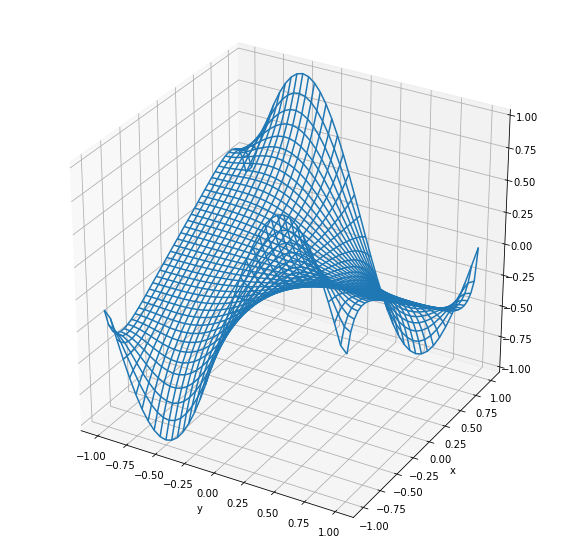

In [9]:
P = P3
x, y, u = solve_helmholtz(P, Nx=40, Ny=40)
plot(x,y,u)

<div id='acknowledgements' />

# Acknowledgements

* _Material creado por profesor Claudio Torres_ (`ctorres@inf.utfsm.cl`) _y ayudantes: Alvaro Salinas y Martín Villanueva. DI UTFSM. Abril 2016._

***
### DISCLAIMER ###

El presente notebook ha sido creado para el curso **ILI286 - Computación Científica 2**, del [Departamento de Informática](http://www.inf.utfsm.cl/), [Universidad Técnica Federico Santa María](http://www.utfsm.cl/). 

El material ha sido creado por Claudio Torres <ctorres@inf.utfsm.cl> y ayudantes, y es distribuido sin restricciones. En caso de encontrar un error, por favor no dude en contactarnos.

[Update 2016] V1.1 (Martín) Integrados los notebook de Poisson y Helmotz en un sólo notebook. Se agregó contexto y marco teórico. 

[Update 2019] (C. Torres) Fixing titles.
***